In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# import data modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree


In [2]:
# load the dataset
data= pd.read_csv("CompleteDataMin.csv")

# Phân loại chuyến bay bị hủy do thời tiết
# Các cột muốn giữ lại
columns_to_keep = ["WIND_GUST", "VISIBILITY", "TEMPERATURE", "ACTIVE_WEATHER", "CANCELLED"]

# Xóa các cột trừ các cột được liệt kê
columns_to_drop = list(set(data.columns) - set(columns_to_keep))
data = data.drop(columns=columns_to_drop)
print("shape of the data:", data.shape)
data.head()

shape of the data: (1048575, 5)


,CANCELLED,WIND_GUST,VISIBILITY,TEMPERATURE,ACTIVE_WEATHER
0,0,0.0,8.0,9.39,0.0
1,0,0.0,10.0,12.22,0.0
2,2,NaN,NaN,NaN,NaN
3,0,0.0,5.0,2.22,1.0
4,0,0.0,10.0,20.00,0.0


In [3]:
# kiểm tra kiểu dữ liệu của cột
data.dtypes

CANCELLED           int64
WIND_GUST         float64
VISIBILITY        float64
TEMPERATURE       float64
ACTIVE_WEATHER    float64
dtype: object

In [4]:
# Xóa các hàng chứa giá trị thiếu
data = data.dropna()

In [5]:
data.isnull().sum()

CANCELLED         0
WIND_GUST         0
VISIBILITY        0
TEMPERATURE       0
ACTIVE_WEATHER    0
dtype: int64

In [6]:
# số lượng lớp mục tiêu
data["CANCELLED"].value_counts()

CANCELLED
0    1001528
2      27476
1      12919
3        752
Name: count, dtype: int64

In [7]:
# Xóa các dòng có CANCELLED khác 0 và 2 vì 2 là lí do chuyến bay bị hủy do thời tiết
data = data[data["CANCELLED"].isin([0, 2])]

# Kiểm tra lại số lượng lớp mục tiêu sau khi xóa
data["CANCELLED"].value_counts()

CANCELLED
0    1001528
2      27476
Name: count, dtype: int64

In [8]:
# Thực hiện undersample để cân bằng dữ liệu (vì dữ liệu bị mất cân bằng)
# Tỉ lệ phần trăm mẫu lớp 0 cần giữ lại 
undersample_percentage = 0.2        

# Tính số lượng mẫu lớp thiểu số và lớp đa số
count_class_0 = 1001528
count_class_1 = 27476

# Tính số lượng mẫu cần giữ lại từ lớp đa số
undersample_count = int(count_class_1 / undersample_percentage)

# Giảm số lượng mẫu lớp đa số theo tỷ lệ phần trăm
undersampled_data = pd.concat([data[data['CANCELLED'] == 0].sample(undersample_count), data[data['CANCELLED'] == 2]])

# Kiểm tra số lượng mẫu trong tập dữ liệu mới
undersampled_data['CANCELLED'].value_counts()


CANCELLED
0    137380
2     27476
Name: count, dtype: int64

In [9]:
data=undersampled_data

In [10]:
# Tỷ lệ phần trăm của lớp có trong biến mục tiêu 
print("Phần trăm của 0 và 2\n",data["CANCELLED"].value_counts()/len(data)*100)

Phần trăm của 0 và 2
 CANCELLED
0    83.333333
2    16.666667
Name: count, dtype: float64


In [11]:
# Chuyển kiểu dữ liệu thành kiểu int
data["WIND_GUST"] = data["WIND_GUST"].astype('int64')
data["VISIBILITY"] = data["VISIBILITY"].astype('int64')
data["TEMPERATURE"] = data["TEMPERATURE"].astype('int64')
data["ACTIVE_WEATHER"] = data["ACTIVE_WEATHER"].astype('int64')

In [12]:
data.dtypes

CANCELLED         int64
WIND_GUST         int64
VISIBILITY        int64
TEMPERATURE       int64
ACTIVE_WEATHER    int64
dtype: object

In [13]:
data.head()

,CANCELLED,WIND_GUST,VISIBILITY,TEMPERATURE,ACTIVE_WEATHER
719743,0,0,10,6,0
304773,0,28,10,4,0
570563,0,0,10,10,0
997689,0,0,10,0,0
715459,0,0,10,3,0


In [14]:
# indentifying the numerical variables
num_var= data.select_dtypes(include=np.number)
num_var.head()

,CANCELLED,WIND_GUST,VISIBILITY,TEMPERATURE,ACTIVE_WEATHER
719743,0,0,10,6,0
304773,0,28,10,4,0
570563,0,0,10,10,0
997689,0,0,10,0,0
715459,0,0,10,3,0


In [15]:
data.describe()

,CANCELLED,WIND_GUST,VISIBILITY,TEMPERATURE,ACTIVE_WEATHER
count,164856.000000,164856.000000,164856.000000,164856.000000,164856.000000
mean,0.333333,3.694588,9.039895,4.919069,0.169560
std,0.745358,8.772723,2.408459,9.689495,0.392271
min,0.000000,0.000000,0.000000,-41.000000,0.000000
25%,0.000000,0.000000,10.000000,-1.000000,0.000000
50%,0.000000,0.000000,10.000000,4.000000,0.000000
75%,0.000000,0.000000,10.000000,12.000000,0.000000
max,2.000000,56.000000,20.000000,35.000000,2.000000


<Axes: >

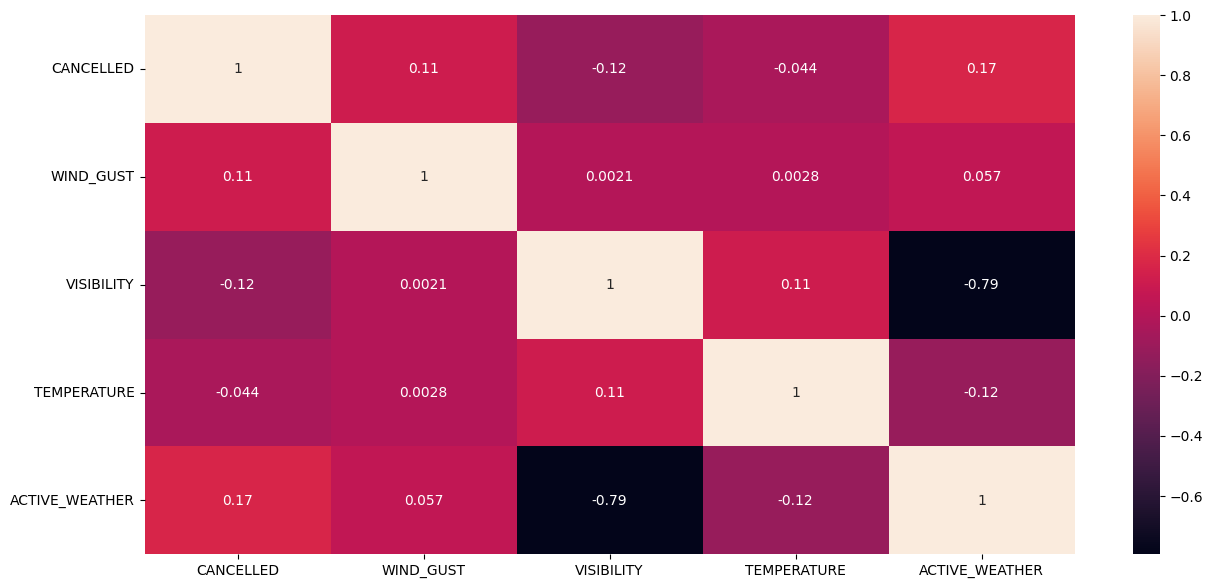

In [16]:
# biểu đồ heatmap của ma trận tương quan
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(), annot=True)
# Ta thấy các ô màu đậm, điều này cho thấy có một mức độ tương quan cao giữa các cặp biến số tương ứng.

In [17]:
# Biến mục tiêu (y)
labels = data.iloc[:, 0]

# Biến đặc trưng (x)
features = data.iloc[:, 1:]

In [18]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [19]:
# viết hàm để in ra các thông số đánh giá hiệu suất của mô hình sau khi được huấn luyện và dự đoán trên tập huấn luyện và tập kiểm tra
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [20]:
# Khởi tạo mô hình Random Forest với 100 cây quyết định
rf = RandomForestClassifier(n_estimators=100)

In [21]:
# Huấn luyện mô hình trên tập huấn luyện
rf.fit(X_train, y_train)

# Predict on the test set results

y_pred = rf.predict(X_test)
print_score(rf, X_train, y_train, X_test, y_test, train=True)
print_score(rf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 87.65%
_______________________________________________
CLASSIFICATION REPORT:
                       0             2  accuracy      macro avg   weighted avg
precision       0.883926      0.784202  0.876498       0.834064       0.867387
recall          0.980729      0.352231  0.876498       0.666480       0.876498
f1-score        0.929815      0.486118  0.876498       0.707967       0.856231
support    110012.000000  21872.000000  0.876498  131884.000000  131884.000000
_______________________________________________
Confusion Matrix: 
 [[107892   2120]
 [ 14168   7704]]

Test Result:
Accuracy Score: 87.19%
_______________________________________________
CLASSIFICATION REPORT:
                      0            2  accuracy     macro avg  weighted avg
precision      0.880008     0.773810  0.871891      0.826909      0.861958
recall         0.979173     0.347966  0.871891      0.663569      0.871891
f1-score       0.926946     0.480059  0.871891      0.703502 

In [22]:
# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác của mô hình: {:.2f}%".format(accuracy * 100))

Độ chính xác của mô hình: 87.19%


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     27368
           2       0.77      0.35      0.48      5604

    accuracy                           0.87     32972
   macro avg       0.83      0.66      0.70     32972
weighted avg       0.86      0.87      0.85     32972



In [24]:
# độ ảnh hưởng của các biến feature

feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

TEMPERATURE       0.487197
WIND_GUST         0.257886
VISIBILITY        0.160083
ACTIVE_WEATHER    0.094834
dtype: float64

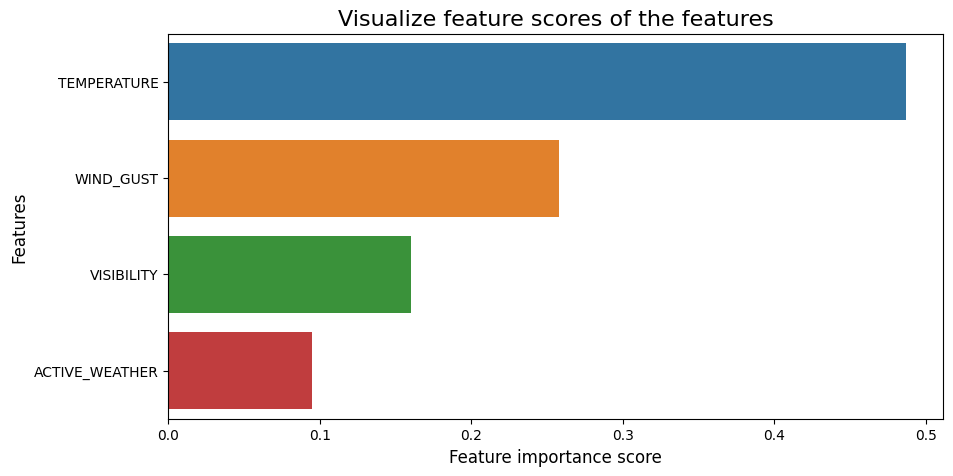

In [37]:
#Vẽ mô hình độ ảnh hưởng của các biến
# Định nghĩa kích thước của biểu đồ
plt.figure(figsize=(10, 5))
# Vẽ biểu đồ bar plot
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
# Đặt tiêu đề cho biểu đồ
ax.set_title("Visualize feature scores of the features", fontsize=16)
# Đặt nhãn trục y cho biểu đồ
ax.set_yticklabels(feature_scores.index)
# Đặt nhãn cho trục x
ax.set_xlabel("Feature importance score", fontsize=12)
# Đặt nhãn cho trục y
ax.set_ylabel("Features", fontsize=12)
# Hiển thị biểu đồ
plt.show()

In [26]:
# biểu diễn ma trận nhầm lẫn

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)



Confusion matrix

 [[26798   570]
 [ 3654  1950]]


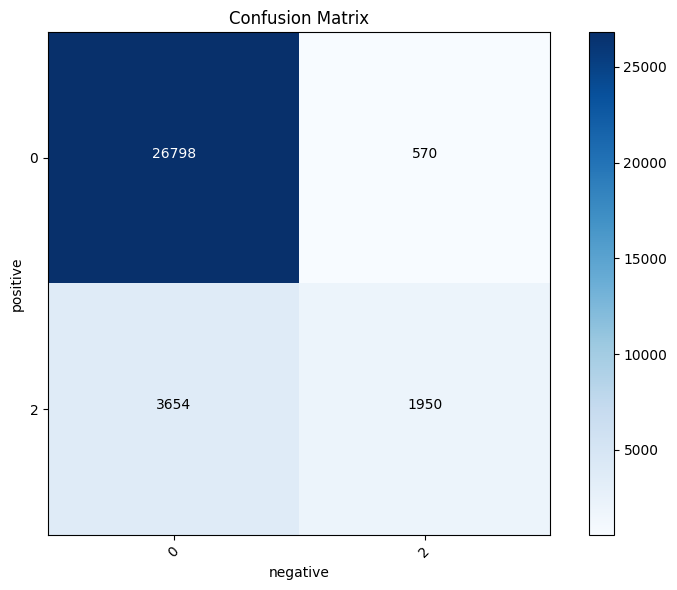

In [27]:
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Tạo danh sách tên các lớp
class_names = np.unique(y_test)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Định dạng và hiển thị các giá trị trên ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("positive")
plt.xlabel("negative")
plt.tight_layout()
plt.show()

75332: mẫu mang nhãn 0 được phân lớp đúng vào lớp 0

1068: mẫu mang nhãn 0 được phân lớp sai vào lớp 2 

11926: mẫu mang nhãn 2 được phân lớp sai vào lớp 0

3345: mẫu mãng nhãn 2 được phân lớp đúng vào lớp 2

In [28]:
data_array = np.array(data)

# In mảng NumPy
print(data_array)

[[ 0  0 10  6  0]
 [ 0 28 10  4  0]
 [ 0  0 10 10  0]
 ...
 [ 2  0  2  2  1]
 [ 2  0  7  6  0]
 [ 2  0 10 -1  0]]


In [29]:

# Dữ liệu đặc trưng (features)
X = data_array[:, 1:]  # Lấy các cột từ cột thứ 2 trở đi

# Dữ liệu nhãn (labels)
y = data_array[:, 0]  # Lấy cột đầu tiên

# Tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)

# Rút tập luật từ mô hình
def extract_rules_from_tree(tree, feature_names, class_names):
    rules = []

    def traverse_tree(node, rule, depth=0):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            feature_index = tree.feature[node]
            threshold = tree.threshold[node]

            rule.append(f"If {feature_names[feature_index]} <= {threshold:.2f}")
            traverse_tree(tree.children_left[node], rule, depth + 1)
            rule.pop()

            rule.append(f"If {feature_names[feature_index]} > {threshold:.2f}")
            traverse_tree(tree.children_right[node], rule, depth + 1)
            rule.pop()
        else:
            class_index = np.argmax(tree.value[node])
            class_label = class_names[class_index]
            rule.append(f"Then class = {class_label}")
            rules.append(" ".join(rule))
            rule.pop()

    feature_names = np.array(feature_names)
    class_names = np.array(class_names)
    tree = model.estimators_[0].tree_
    traverse_tree(0, [])

    return rules

# Truy xuất các tập luật từ mô hình Random Forest
feature_names = ['WIND_GUST', 'VISIBILITY', 'TEMPERATURE', 'ACTIVE_WEATHER']
class_names = ['0', '2']
rules = extract_rules_from_tree(model.estimators_[0].tree_, feature_names, class_names)

# In các tập luật
for i, rule in enumerate(rules):
    print(f"Rule {i+1}: {rule}")


Rule 1: If ACTIVE_WEATHER <= 0.50 If WIND_GUST <= 20.50 If TEMPERATURE <= 0.50 If WIND_GUST <= 13.50 If VISIBILITY <= 8.50 If TEMPERATURE <= -1.50 If VISIBILITY <= 7.50 If VISIBILITY <= 6.50 Then class = 0
Rule 2: If ACTIVE_WEATHER <= 0.50 If WIND_GUST <= 20.50 If TEMPERATURE <= 0.50 If WIND_GUST <= 13.50 If VISIBILITY <= 8.50 If TEMPERATURE <= -1.50 If VISIBILITY <= 7.50 If VISIBILITY > 6.50 If TEMPERATURE <= -7.50 If TEMPERATURE <= -13.50 If TEMPERATURE <= -19.50 If TEMPERATURE <= -21.00 Then class = 0
Rule 3: If ACTIVE_WEATHER <= 0.50 If WIND_GUST <= 20.50 If TEMPERATURE <= 0.50 If WIND_GUST <= 13.50 If VISIBILITY <= 8.50 If TEMPERATURE <= -1.50 If VISIBILITY <= 7.50 If VISIBILITY > 6.50 If TEMPERATURE <= -7.50 If TEMPERATURE <= -13.50 If TEMPERATURE <= -19.50 If TEMPERATURE > -21.00 Then class = 0
Rule 4: If ACTIVE_WEATHER <= 0.50 If WIND_GUST <= 20.50 If TEMPERATURE <= 0.50 If WIND_GUST <= 13.50 If VISIBILITY <= 8.50 If TEMPERATURE <= -1.50 If VISIBILITY <= 7.50 If VISIBILITY > 6.

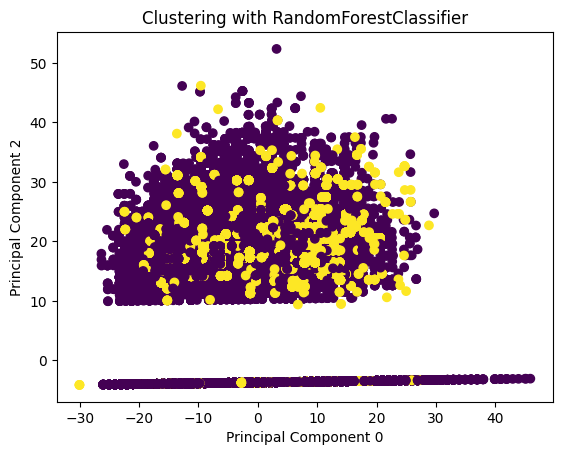

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Dữ liệu đặc trưng (features)
X = data_array[:, 1:]  # Lấy các cột từ cột thứ 2 trở đi
# Dữ liệu nhãn (labels)
y = data_array[:, 0]  # Lấy cột đầu tiên
model.fit(X, y)
# Sử dụng phân tích thành phần chính (PCA) để giảm chiều dữ liệu xuống 2 chiều
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Phân cụm dữ liệu sử dụng RandomForestClassifier
clusters = model.predict(X)
# Vẽ đồ thị các mô hình phân cụm
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 2')
plt.title('Clustering with RandomForestClassifier')
plt.show()
